# Copy data from gdrive and prepare folder structure

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


#

In [2]:
# where the zipped data are on gdrive
PROJECT_FOLDER = "/gdrive/MyDrive/Projects/solafune-mining_sites/data"

# where we will unpack data
DATA_FOLDER = "/home/data/"
TRAIN_DATA_FOLDER = DATA_FOLDER + 'train/'
TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

In [3]:
import os

# In the project data folder we expect 3 files
competition_data_files = os.listdir(PROJECT_FOLDER)
print(competition_data_files)
assert("train.zip" in competition_data_files)
assert("evaluation_images.zip" in competition_data_files)
assert("uploadsample.csv" in competition_data_files)

['train.zip', 'uploadsample.csv', 'evaluation_images.zip']


In [4]:
# copy and unzip data from gdrive to colab
!rm -rf {DATA_FOLDER}
!cp -r {PROJECT_FOLDER} /home/
!mkdir {TEST_DATA_FOLDER}

!unzip -qq {DATA_FOLDER}/train.zip -d {DATA_FOLDER}
!unzip -qq {DATA_FOLDER}/evaluation_images.zip -d {TEST_DATA_FOLDER}

In [5]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.1 MB/s eta 0:00:00


# Imports

In [6]:
import os
import random
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [7]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

# Load train data

In [8]:
train_data = pd.read_csv(f'{DATA_FOLDER}answer.csv', names=["file_name", "label"], header=None)

# Dataset

## Data augmentations

We can use [torchvision v2 transforms](https://pytorch.org/vision/stable/transforms.html) or [albumentations](https://github.com/albumentations-team/albumentations) for data augmentation to reduce overfitting.

In [9]:
train_transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomRotation(degrees=90),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float32, scale=False),
])


val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=False),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Feature engineering

Different surfaces absorb and reflect different amount of radiation based on their physical and chemical properties. You can find some papers about the reflactance of different materials. For example:

![Spectral reflectance curves of different land cover/use (LCU) types](https://www.mdpi.com/remotesensing/remotesensing-11-00345/article_deploy/html/images/remotesensing-11-00345-g002-550.jpg "Spectral reflectance curves of different land cover/use (LCU) types")

Source: https://www.mdpi.com/2072-4292/11/3/345


We can use combinations of bands to focus on specific ranges to enhance features or spectral signatures of interest. These combinations are called band indices.

Commonly used indices in remote sensing are for example:
- [Normalized Difference Vegetation Index](https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/):
NDVI = (NIR - R) / (NIR + R)
- [Normalized Difference Water Index](https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/): NDWI = (NIR - G) / (NIR + G)
- [Normalized Difference Moisture Index](): NDMI = (NIR - SWIR_1) / (NIR + SWIR_1)
- [Enhanced Vegetation Index](https://custom-scripts.sentinel-hub.com/sentinel-2/evi/): EVI = 2.5 * (NIR - RED) / ((NIR + 6 * RED - 7.5 * BLUE) + 1)

You can try to create your own combinations that works for this competition or try some of existing indices. Here are some sources where you can find them:
- https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/
- https://www.indexdatabase.de/db/i.php

In [10]:
def feature_engineering(image):
    endmi = ((image[..., 7] + image[..., 8]) - (image[..., 10] + image[..., 11])) / (image[..., 7] + image[..., 8] + image[..., 10] + image[..., 10] + image[..., 11] + 1e-10)
    ndvi = (image[..., 7] - image[..., 3]) / (image[..., 7] + image[..., 3] + 1e-10)

    image = np.concatenate(
        [
            image * 2 - 1, # scale band data from -1 to 1
            np.expand_dims(endmi, axis=-1),
            np.expand_dims(ndvi, axis=-1),
        ],
        axis=-1,
    )
    return image

In [11]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = tifffile.imread(f"{self.folder}{d.file_name}")
        image = feature_engineering(np.array(image))
        image = self.transforms(image)
        label = d.label

        return {"image": image, "label": torch.tensor(label, dtype=torch.long)}

## Visualize it

In [12]:
bands = [
    ["B1", "Aerosols", "60 meters"],
    ["B2", "Blue", "10 meters"],
    ["B3", "Green", "10 meters"],
    ["B4", "Red", "10 meters"],
    ["B5", "Red Edge 1", "20 meters"],
    ["B6", "Red Edge 2", "20 meters"],
    ["B7", "Red Edge 3", "20 meters"],
    ["B8", "NIR", "10 meters"],
    ["B8A", "Red Edge 4", "20 meters"],
    ["B9", "Water vapor", "60 meters"],
    ["B11", "SWIR 1", "20 meters"],
    ["B12", "SWIR 2", "20 meters"],
    ["", "NDMI", ""],
    ["", "NDVI", ""],
    ]

torch.Size([14, 512, 512]) tensor(1)
Band data stats:
bands min: [-0.97 -0.96 -0.94 -0.97 -0.98 -1.   -1.   -1.   -1.   -0.99 -0.96 -0.96
 -0.67 -1.  ]
bands mean: [-0.68 -0.63 -0.52 -0.43 -0.37 -0.31 -0.28 -0.27 -0.26 -0.25 -0.18 -0.29
 -0.02  0.12]
bands max: [0.   0.   0.   0.15 0.25 0.24 0.25 0.28 0.25 0.23 0.41 0.19 0.53 0.83]


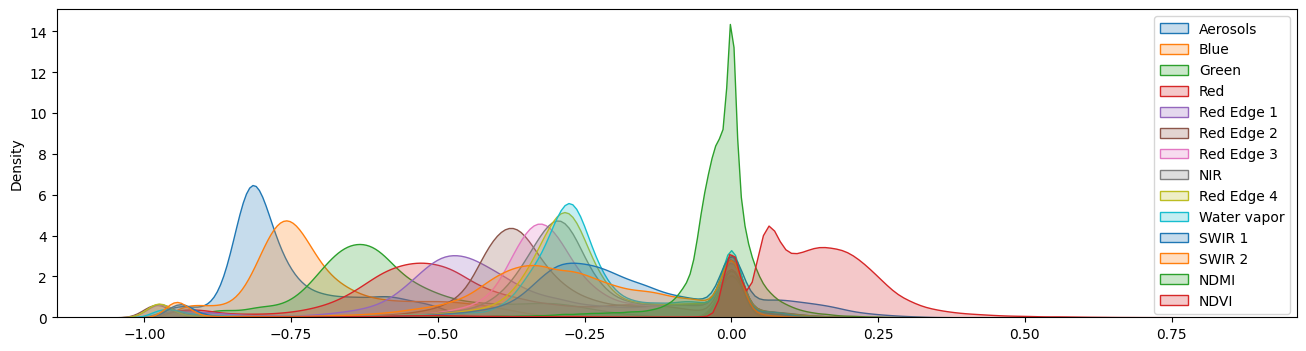

In [13]:
ds = ImageTrainDataset(f'{TRAIN_DATA_FOLDER}', train_data, transforms=train_transforms)

d = ds.__getitem__(20)
print(d["image"].shape, d["label"])

img = d["image"]
print("Band data stats:")
print("bands min:", np.round(torch.min(img.flatten(1), dim=1)[0].numpy(), 2))
print("bands mean:", np.round(torch.mean(img.flatten(1), dim=1).numpy(), 2))
print("bands max:", np.round(torch.max(img.flatten(1), dim=1)[0].numpy(), 2))

fig, ax = plt.subplots(figsize=(16,4))
for i in range(img.shape[0]):
    sns.kdeplot(img[i, :].flatten(), fill=True, label=bands[i][1],ax=ax)
plt.legend()
plt.show()

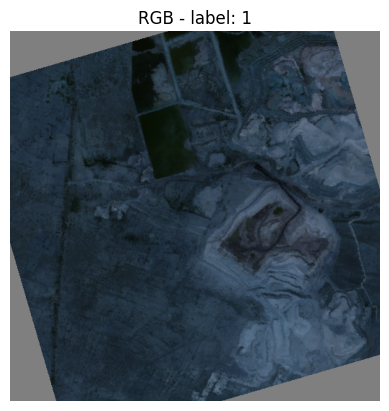

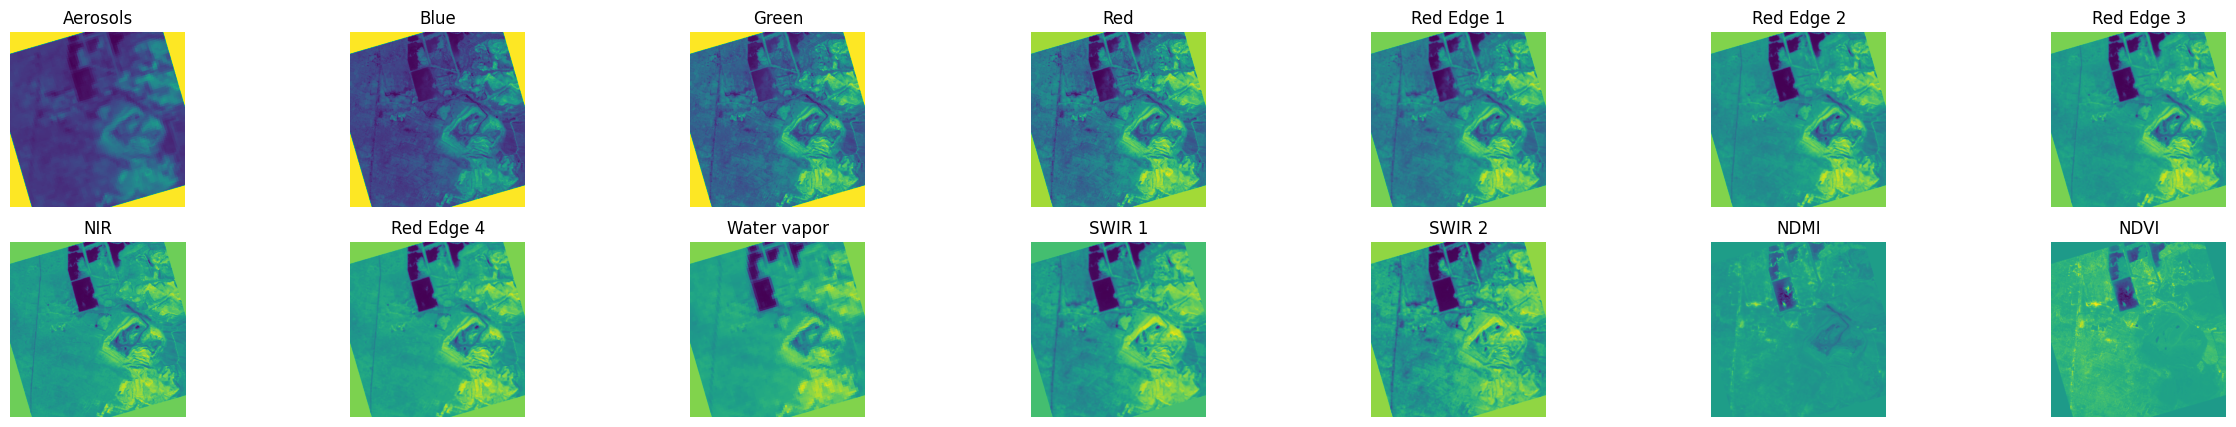

In [14]:
img = d["image"] / 2 + 0.5 # just for the imshow scale image values between 0 and 1
plt.figure()
plt.imshow(img[1:4].permute(1,2,0))
plt.title("RGB - label: " + str(d["label"].numpy()))
plt.axis('off')
plt.show()

fig, axes = plt.subplots(2,img.shape[0]//2, figsize=(30,5))
axes = axes.ravel()
for i in range(img.shape[0]):
    axes[i].imshow(img[i,:,:])
    axes[i].title.set_text(bands[i][1])
    axes[i].axis('off')
plt.show()

# Metric

In [15]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix

In [16]:
def find_best_threshold(targets, predictions):
    score_5 = sklearn_f1(targets, predictions > 0.5)
    best_score = 0
    best_th = -1
    for i in range(100):
        threshold =  i/100
        _score = sklearn_f1(targets, predictions > threshold)
        if _score > best_score:
            best_score = _score
            best_th = threshold

    tn, fp, fn, tp = confusion_matrix(targets.numpy(), predictions.numpy() > best_th).ravel()
    print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
    return score_5, best_score, best_th

# Train and evaluate functions

In [17]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [18]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [19]:
def evaluate_model(cfg, model, data_loader, epoch=-1):
    loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(cfg.device), label_smoothing=0.1)

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["label"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        loss = loss_fn(logits, target)
        val_loss += loss.item()

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    val_loss /= total_len
    base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])

    print(f'Epoch {epoch} validation loss = {val_loss:.4f}, base f1 score (0.5 threshold) = {base_score:.4f} (best threhold: {best_th} -> f1 {best_score:.4f})')
    return val_loss, best_score

In [20]:
def train_epoch(cfg, model, train_loader, optimizer, scheduler, epoch):
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(cfg.device), label_smoothing=0.1)

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)
        target = data["label"].to(cfg.device, non_blocking=True)

        # https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            logits = model(input)
            loss = loss_fn(logits, target)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del input, target

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)

    train_loss /= total_len
    base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])

    print(f'Epoch {epoch} train loss = {train_loss:.4f}, base f1 score (0.5 threshold) = {base_score:.4f} (best threhold: {best_th} -> f1 {best_score:.4f})')
    return train_loss, best_score, learning_rate_history

# Train model

In [21]:
# list timms maxvit models models
timm.list_models("maxvit*512")

['maxvit_base_tf_512',
 'maxvit_large_tf_512',
 'maxvit_small_tf_512',
 'maxvit_tiny_tf_512',
 'maxvit_xlarge_tf_512']

In [22]:
class CFG:
    seed=42
    N_folds = 5
    train_folds = [0, 1] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision

    model_name = "maxvit_tiny_tf_512"
    epochs = 20
    weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 16
    gradient_accumulation_steps = 1

    lr = 1e-4
    weight_decay=1e-2

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

<Axes: xlabel='label', ylabel='Count'>

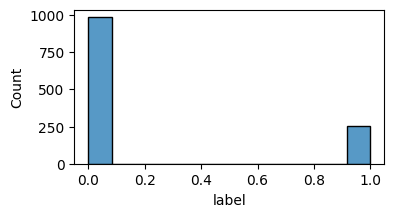

In [23]:
plt.figure(figsize=(4,2))
sns.histplot(train_data["label"])

In [24]:
from sklearn.model_selection import StratifiedKFold

sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["file_name"].values, train_data["label"].values)):
    train_data.loc[test_index, "fold"] = i

## Train folds

,0,1
label,0,1
valid,198,51
train,788,205


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

Model parameters: 30_543_946


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 0 training 62/62 [LR 0.000099] - loss: 0.5742: 100%|██████████| 62/62 [02:32<00:00,  2.46s/it]


tp: 114, tn: 734, fp: 54, fn: 90
Epoch 0 train loss = 0.5742, base f1 score (0.5 threshold) = 0.5767 (best threhold: 0.58 -> f1 0.6129)


100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


tp: 38, tn: 180, fp: 18, fn: 13
Epoch 0 validation loss = 0.5531, base f1 score (0.5 threshold) = 0.6780 (best threhold: 0.55 -> f1 0.7103)
New best score: 0.0000 -> 0.7103


Epoch 1 training 62/62 [LR 0.000098] - loss: 0.4860: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 164, tn: 726, fp: 61, fn: 41
Epoch 1 train loss = 0.4860, base f1 score (0.5 threshold) = 0.7295 (best threhold: 0.57 -> f1 0.7628)


100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


tp: 35, tn: 195, fp: 3, fn: 16
Epoch 1 validation loss = 0.5319, base f1 score (0.5 threshold) = 0.6076 (best threhold: 0.8 -> f1 0.7865)
New best score: 0.7103 -> 0.7865


Epoch 2 training 62/62 [LR 0.000095] - loss: 0.4255: 100%|██████████| 62/62 [02:29<00:00,  2.42s/it]


tp: 169, tn: 766, fp: 21, fn: 36
Epoch 2 train loss = 0.4255, base f1 score (0.5 threshold) = 0.7991 (best threhold: 0.65 -> f1 0.8557)


100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


tp: 37, tn: 188, fp: 10, fn: 14
Epoch 2 validation loss = 0.5655, base f1 score (0.5 threshold) = 0.6533 (best threhold: 0.81 -> f1 0.7551)


Epoch 3 training 62/62 [LR 0.000091] - loss: 0.4150: 100%|██████████| 62/62 [02:31<00:00,  2.44s/it]


tp: 176, tn: 765, fp: 23, fn: 28
Epoch 3 train loss = 0.4150, base f1 score (0.5 threshold) = 0.8525 (best threhold: 0.59 -> f1 0.8734)


100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


tp: 42, tn: 179, fp: 19, fn: 9
Epoch 3 validation loss = 0.5609, base f1 score (0.5 threshold) = 0.7238 (best threhold: 0.44 -> f1 0.7500)


Epoch 4 training 62/62 [LR 0.000086] - loss: 0.3854: 100%|██████████| 62/62 [02:30<00:00,  2.42s/it]


tp: 182, tn: 777, fp: 10, fn: 23
Epoch 4 train loss = 0.3854, base f1 score (0.5 threshold) = 0.9100 (best threhold: 0.6 -> f1 0.9169)


100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


tp: 44, tn: 186, fp: 12, fn: 7
Epoch 4 validation loss = 0.5576, base f1 score (0.5 threshold) = 0.7368 (best threhold: 0.35 -> f1 0.8224)
New best score: 0.7865 -> 0.8224


Epoch 5 training 62/62 [LR 0.000080] - loss: 0.3883: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 190, tn: 776, fp: 11, fn: 15
Epoch 5 train loss = 0.3883, base f1 score (0.5 threshold) = 0.9314 (best threhold: 0.54 -> f1 0.9360)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 43, tn: 187, fp: 11, fn: 8
Epoch 5 validation loss = 0.5035, base f1 score (0.5 threshold) = 0.8119 (best threhold: 0.43 -> f1 0.8190)


Epoch 6 training 62/62 [LR 0.000073] - loss: 0.3938: 100%|██████████| 62/62 [02:31<00:00,  2.45s/it]


tp: 180, tn: 778, fp: 9, fn: 25
Epoch 6 train loss = 0.3938, base f1 score (0.5 threshold) = 0.8971 (best threhold: 0.63 -> f1 0.9137)


100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


tp: 44, tn: 194, fp: 4, fn: 7
Epoch 6 validation loss = 0.4516, base f1 score (0.5 threshold) = 0.8174 (best threhold: 0.83 -> f1 0.8889)
New best score: 0.8224 -> 0.8889


Epoch 7 training 62/62 [LR 0.000066] - loss: 0.3705: 100%|██████████| 62/62 [02:28<00:00,  2.39s/it]


tp: 187, tn: 778, fp: 9, fn: 18
Epoch 7 train loss = 0.3705, base f1 score (0.5 threshold) = 0.9272 (best threhold: 0.72 -> f1 0.9327)


100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


tp: 48, tn: 183, fp: 15, fn: 3
Epoch 7 validation loss = 0.4583, base f1 score (0.5 threshold) = 0.7385 (best threhold: 0.66 -> f1 0.8421)


Epoch 8 training 62/62 [LR 0.000058] - loss: 0.3587: 100%|██████████| 62/62 [02:30<00:00,  2.42s/it]


tp: 191, tn: 782, fp: 5, fn: 14
Epoch 8 train loss = 0.3587, base f1 score (0.5 threshold) = 0.9353 (best threhold: 0.72 -> f1 0.9526)


100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


tp: 45, tn: 185, fp: 13, fn: 6
Epoch 8 validation loss = 0.5341, base f1 score (0.5 threshold) = 0.7705 (best threhold: 0.81 -> f1 0.8257)


Epoch 9 training 62/62 [LR 0.000051] - loss: 0.3776: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 189, tn: 779, fp: 8, fn: 16
Epoch 9 train loss = 0.3776, base f1 score (0.5 threshold) = 0.9317 (best threhold: 0.8 -> f1 0.9403)


100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


tp: 42, tn: 190, fp: 8, fn: 9
Epoch 9 validation loss = 0.5087, base f1 score (0.5 threshold) = 0.8200 (best threhold: 0.45 -> f1 0.8317)


Epoch 10 training 62/62 [LR 0.000043] - loss: 0.3541: 100%|██████████| 62/62 [02:32<00:00,  2.46s/it]


tp: 198, tn: 779, fp: 8, fn: 7
Epoch 10 train loss = 0.3541, base f1 score (0.5 threshold) = 0.9576 (best threhold: 0.37 -> f1 0.9635)


100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


tp: 43, tn: 191, fp: 7, fn: 8
Epoch 10 validation loss = 0.4893, base f1 score (0.5 threshold) = 0.8333 (best threhold: 0.82 -> f1 0.8515)


Epoch 11 training 62/62 [LR 0.000035] - loss: 0.3217: 100%|██████████| 62/62 [02:31<00:00,  2.45s/it]


tp: 200, tn: 785, fp: 2, fn: 5
Epoch 11 train loss = 0.3217, base f1 score (0.5 threshold) = 0.9804 (best threhold: 0.63 -> f1 0.9828)


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


tp: 47, tn: 186, fp: 12, fn: 4
Epoch 11 validation loss = 0.4769, base f1 score (0.5 threshold) = 0.8174 (best threhold: 0.58 -> f1 0.8545)


Epoch 12 training 62/62 [LR 0.000028] - loss: 0.3319: 100%|██████████| 62/62 [02:31<00:00,  2.44s/it]


tp: 200, tn: 784, fp: 3, fn: 5
Epoch 12 train loss = 0.3319, base f1 score (0.5 threshold) = 0.9757 (best threhold: 0.68 -> f1 0.9804)


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


tp: 43, tn: 184, fp: 14, fn: 8
Epoch 12 validation loss = 0.5915, base f1 score (0.5 threshold) = 0.7244 (best threhold: 0.89 -> f1 0.7963)


Epoch 13 training 62/62 [LR 0.000021] - loss: 0.3102: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 205, tn: 782, fp: 5, fn: 0
Epoch 13 train loss = 0.3102, base f1 score (0.5 threshold) = 0.9880 (best threhold: 0.42 -> f1 0.9880)


100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


tp: 43, tn: 190, fp: 8, fn: 8
Epoch 13 validation loss = 0.5007, base f1 score (0.5 threshold) = 0.8269 (best threhold: 0.64 -> f1 0.8431)


Epoch 14 training 62/62 [LR 0.000015] - loss: 0.3285: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 203, tn: 781, fp: 6, fn: 2
Epoch 14 train loss = 0.3285, base f1 score (0.5 threshold) = 0.9807 (best threhold: 0.49 -> f1 0.9807)


100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


tp: 43, tn: 190, fp: 8, fn: 8
Epoch 14 validation loss = 0.4960, base f1 score (0.5 threshold) = 0.8431 (best threhold: 0.48 -> f1 0.8431)


Epoch 15 training 62/62 [LR 0.000010] - loss: 0.3173: 100%|██████████| 62/62 [02:32<00:00,  2.46s/it]


tp: 203, tn: 785, fp: 2, fn: 2
Epoch 15 train loss = 0.3173, base f1 score (0.5 threshold) = 0.9902 (best threhold: 0.44 -> f1 0.9902)


100%|██████████| 16/16 [00:23<00:00,  1.50s/it]


tp: 41, tn: 193, fp: 5, fn: 10
Epoch 15 validation loss = 0.4986, base f1 score (0.5 threshold) = 0.8400 (best threhold: 0.84 -> f1 0.8454)


Epoch 16 training 62/62 [LR 0.000006] - loss: 0.3121: 100%|██████████| 62/62 [02:30<00:00,  2.42s/it]


tp: 203, tn: 788, fp: 0, fn: 1
Epoch 16 train loss = 0.3121, base f1 score (0.5 threshold) = 0.9902 (best threhold: 0.86 -> f1 0.9975)


100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


tp: 41, tn: 194, fp: 4, fn: 10
Epoch 16 validation loss = 0.4950, base f1 score (0.5 threshold) = 0.8367 (best threhold: 0.8 -> f1 0.8542)


Epoch 17 training 62/62 [LR 0.000003] - loss: 0.3129: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 203, tn: 787, fp: 0, fn: 2
Epoch 17 train loss = 0.3129, base f1 score (0.5 threshold) = 0.9927 (best threhold: 0.68 -> f1 0.9951)


100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


tp: 42, tn: 192, fp: 6, fn: 9
Epoch 17 validation loss = 0.4988, base f1 score (0.5 threshold) = 0.8367 (best threhold: 0.43 -> f1 0.8485)


Epoch 18 training 62/62 [LR 0.000002] - loss: 0.3103: 100%|██████████| 62/62 [02:31<00:00,  2.44s/it]


tp: 202, tn: 788, fp: 0, fn: 2
Epoch 18 train loss = 0.3103, base f1 score (0.5 threshold) = 0.9902 (best threhold: 0.63 -> f1 0.9951)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 41, tn: 193, fp: 5, fn: 10
Epoch 18 validation loss = 0.4945, base f1 score (0.5 threshold) = 0.8400 (best threhold: 0.8 -> f1 0.8454)


Epoch 19 training 62/62 [LR 0.000001] - loss: 0.3084: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 204, tn: 787, fp: 1, fn: 0
Epoch 19 train loss = 0.3084, base f1 score (0.5 threshold) = 0.9976 (best threhold: 0.39 -> f1 0.9976)


100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


tp: 42, tn: 192, fp: 6, fn: 9
Epoch 19 validation loss = 0.4973, base f1 score (0.5 threshold) = 0.8485 (best threhold: 0.43 -> f1 0.8485)


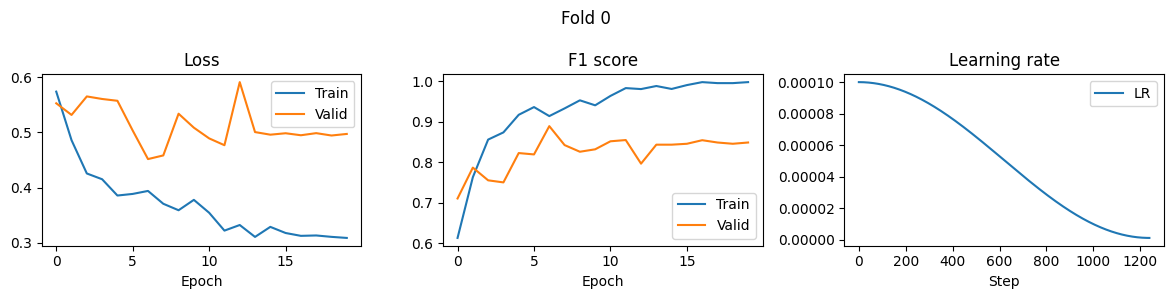

,0,1
label,0,1
valid,197,52
train,789,204


Model parameters: 30_543_946


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 0 training 62/62 [LR 0.000099] - loss: 0.5761: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]


tp: 117, tn: 722, fp: 66, fn: 87
Epoch 0 train loss = 0.5761, base f1 score (0.5 threshold) = 0.5349 (best threhold: 0.61 -> f1 0.6047)


100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


tp: 41, tn: 186, fp: 11, fn: 11
Epoch 0 validation loss = 0.4861, base f1 score (0.5 threshold) = 0.7460 (best threhold: 0.62 -> f1 0.7885)
New best score: 0.0000 -> 0.7885


Epoch 1 training 62/62 [LR 0.000098] - loss: 0.4642: 100%|██████████| 62/62 [02:32<00:00,  2.46s/it]


tp: 158, tn: 750, fp: 38, fn: 46
Epoch 1 train loss = 0.4642, base f1 score (0.5 threshold) = 0.7495 (best threhold: 0.61 -> f1 0.7900)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 47, tn: 184, fp: 13, fn: 5
Epoch 1 validation loss = 0.4628, base f1 score (0.5 threshold) = 0.7133 (best threhold: 0.68 -> f1 0.8393)
New best score: 0.7885 -> 0.8393


Epoch 2 training 62/62 [LR 0.000095] - loss: 0.4392: 100%|██████████| 62/62 [02:31<00:00,  2.44s/it]


tp: 154, tn: 775, fp: 13, fn: 50
Epoch 2 train loss = 0.4392, base f1 score (0.5 threshold) = 0.7884 (best threhold: 0.67 -> f1 0.8302)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 41, tn: 195, fp: 2, fn: 11
Epoch 2 validation loss = 0.4264, base f1 score (0.5 threshold) = 0.8099 (best threhold: 0.66 -> f1 0.8632)
New best score: 0.8393 -> 0.8632


Epoch 3 training 62/62 [LR 0.000091] - loss: 0.4123: 100%|██████████| 62/62 [02:31<00:00,  2.45s/it]


tp: 180, tn: 759, fp: 29, fn: 24
Epoch 3 train loss = 0.4123, base f1 score (0.5 threshold) = 0.8315 (best threhold: 0.56 -> f1 0.8717)


100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


tp: 38, tn: 195, fp: 2, fn: 14
Epoch 3 validation loss = 0.4925, base f1 score (0.5 threshold) = 0.7961 (best threhold: 0.63 -> f1 0.8261)


Epoch 4 training 62/62 [LR 0.000086] - loss: 0.3998: 100%|██████████| 62/62 [02:32<00:00,  2.46s/it]


tp: 180, tn: 769, fp: 20, fn: 23
Epoch 4 train loss = 0.3998, base f1 score (0.5 threshold) = 0.8910 (best threhold: 0.57 -> f1 0.8933)


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


tp: 38, tn: 194, fp: 3, fn: 14
Epoch 4 validation loss = 0.4701, base f1 score (0.5 threshold) = 0.7111 (best threhold: 0.84 -> f1 0.8172)


Epoch 5 training 62/62 [LR 0.000080] - loss: 0.3851: 100%|██████████| 62/62 [02:32<00:00,  2.47s/it]


tp: 182, tn: 772, fp: 17, fn: 21
Epoch 5 train loss = 0.3851, base f1 score (0.5 threshold) = 0.8863 (best threhold: 0.64 -> f1 0.9055)


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


tp: 40, tn: 193, fp: 4, fn: 12
Epoch 5 validation loss = 0.5147, base f1 score (0.5 threshold) = 0.8333 (best threhold: 0.5 -> f1 0.8333)


Epoch 6 training 62/62 [LR 0.000073] - loss: 0.3785: 100%|██████████| 62/62 [02:32<00:00,  2.46s/it]


tp: 189, tn: 773, fp: 15, fn: 15
Epoch 6 train loss = 0.3785, base f1 score (0.5 threshold) = 0.9265 (best threhold: 0.5 -> f1 0.9265)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 48, tn: 188, fp: 9, fn: 4
Epoch 6 validation loss = 0.4651, base f1 score (0.5 threshold) = 0.8627 (best threhold: 0.44 -> f1 0.8807)
New best score: 0.8632 -> 0.8807


Epoch 7 training 62/62 [LR 0.000066] - loss: 0.3491: 100%|██████████| 62/62 [02:34<00:00,  2.50s/it]


tp: 191, tn: 782, fp: 7, fn: 12
Epoch 7 train loss = 0.3491, base f1 score (0.5 threshold) = 0.9463 (best threhold: 0.64 -> f1 0.9526)


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


tp: 46, tn: 191, fp: 6, fn: 6
Epoch 7 validation loss = 0.4272, base f1 score (0.5 threshold) = 0.8738 (best threhold: 0.47 -> f1 0.8846)
New best score: 0.8807 -> 0.8846


Epoch 8 training 62/62 [LR 0.000058] - loss: 0.3839: 100%|██████████| 62/62 [02:33<00:00,  2.48s/it]


tp: 184, tn: 772, fp: 16, fn: 20
Epoch 8 train loss = 0.3839, base f1 score (0.5 threshold) = 0.9038 (best threhold: 0.61 -> f1 0.9109)


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


tp: 42, tn: 192, fp: 5, fn: 10
Epoch 8 validation loss = 0.4210, base f1 score (0.5 threshold) = 0.8182 (best threhold: 0.65 -> f1 0.8485)


Epoch 9 training 62/62 [LR 0.000051] - loss: 0.3747: 100%|██████████| 62/62 [02:32<00:00,  2.47s/it]


tp: 184, tn: 780, fp: 8, fn: 20
Epoch 9 train loss = 0.3747, base f1 score (0.5 threshold) = 0.9212 (best threhold: 0.59 -> f1 0.9293)


100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


tp: 46, tn: 192, fp: 5, fn: 6
Epoch 9 validation loss = 0.4179, base f1 score (0.5 threshold) = 0.8932 (best threhold: 0.5 -> f1 0.8932)
New best score: 0.8846 -> 0.8932


Epoch 10 training 62/62 [LR 0.000043] - loss: 0.3411: 100%|██████████| 62/62 [02:34<00:00,  2.50s/it]


tp: 198, tn: 783, fp: 5, fn: 6
Epoch 10 train loss = 0.3411, base f1 score (0.5 threshold) = 0.9684 (best threhold: 0.51 -> f1 0.9730)


100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


tp: 46, tn: 190, fp: 7, fn: 6
Epoch 10 validation loss = 0.4676, base f1 score (0.5 threshold) = 0.7846 (best threhold: 0.88 -> f1 0.8762)


Epoch 11 training 62/62 [LR 0.000035] - loss: 0.3216: 100%|██████████| 62/62 [02:31<00:00,  2.45s/it]


tp: 199, tn: 786, fp: 2, fn: 5
Epoch 11 train loss = 0.3216, base f1 score (0.5 threshold) = 0.9780 (best threhold: 0.63 -> f1 0.9827)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 49, tn: 191, fp: 6, fn: 3
Epoch 11 validation loss = 0.4051, base f1 score (0.5 threshold) = 0.8846 (best threhold: 0.42 -> f1 0.9159)
New best score: 0.8932 -> 0.9159


Epoch 12 training 62/62 [LR 0.000028] - loss: 0.3172: 100%|██████████| 62/62 [02:31<00:00,  2.45s/it]


tp: 202, tn: 786, fp: 2, fn: 2
Epoch 12 train loss = 0.3172, base f1 score (0.5 threshold) = 0.9830 (best threhold: 0.58 -> f1 0.9902)


100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


tp: 47, tn: 193, fp: 4, fn: 5
Epoch 12 validation loss = 0.4282, base f1 score (0.5 threshold) = 0.8522 (best threhold: 0.88 -> f1 0.9126)


Epoch 13 training 62/62 [LR 0.000021] - loss: 0.3206: 100%|██████████| 62/62 [02:34<00:00,  2.49s/it]


tp: 203, tn: 785, fp: 3, fn: 1
Epoch 13 train loss = 0.3206, base f1 score (0.5 threshold) = 0.9831 (best threhold: 0.6 -> f1 0.9902)


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


tp: 45, tn: 192, fp: 5, fn: 7
Epoch 13 validation loss = 0.4339, base f1 score (0.5 threshold) = 0.8547 (best threhold: 0.89 -> f1 0.8824)


Epoch 14 training 62/62 [LR 0.000015] - loss: 0.3169: 100%|██████████| 62/62 [02:32<00:00,  2.45s/it]


tp: 204, tn: 785, fp: 3, fn: 0
Epoch 14 train loss = 0.3169, base f1 score (0.5 threshold) = 0.9902 (best threhold: 0.4 -> f1 0.9927)


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


tp: 47, tn: 192, fp: 5, fn: 5
Epoch 14 validation loss = 0.4137, base f1 score (0.5 threshold) = 0.8785 (best threhold: 0.73 -> f1 0.9038)


Epoch 15 training 62/62 [LR 0.000010] - loss: 0.3039: 100%|██████████| 62/62 [02:33<00:00,  2.47s/it]


tp: 204, tn: 788, fp: 0, fn: 0
Epoch 15 train loss = 0.3039, base f1 score (0.5 threshold) = 1.0000 (best threhold: 0.45 -> f1 1.0000)


100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


tp: 47, tn: 192, fp: 5, fn: 5
Epoch 15 validation loss = 0.4113, base f1 score (0.5 threshold) = 0.8807 (best threhold: 0.72 -> f1 0.9038)


Epoch 16 training 62/62 [LR 0.000006] - loss: 0.3076: 100%|██████████| 62/62 [02:33<00:00,  2.48s/it]


tp: 204, tn: 787, fp: 1, fn: 0
Epoch 16 train loss = 0.3076, base f1 score (0.5 threshold) = 0.9976 (best threhold: 0.45 -> f1 0.9976)


100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


tp: 46, tn: 193, fp: 4, fn: 6
Epoch 16 validation loss = 0.4173, base f1 score (0.5 threshold) = 0.8704 (best threhold: 0.85 -> f1 0.9020)


Epoch 17 training 62/62 [LR 0.000003] - loss: 0.3191: 100%|██████████| 62/62 [02:33<00:00,  2.47s/it]


tp: 202, tn: 787, fp: 2, fn: 1
Epoch 17 train loss = 0.3191, base f1 score (0.5 threshold) = 0.9901 (best threhold: 0.4 -> f1 0.9926)


100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


tp: 46, tn: 193, fp: 4, fn: 6
Epoch 17 validation loss = 0.4146, base f1 score (0.5 threshold) = 0.8868 (best threhold: 0.67 -> f1 0.9020)


Epoch 18 training 62/62 [LR 0.000002] - loss: 0.3098: 100%|██████████| 62/62 [02:33<00:00,  2.48s/it]


tp: 203, tn: 788, fp: 0, fn: 1
Epoch 18 train loss = 0.3098, base f1 score (0.5 threshold) = 0.9975 (best threhold: 0.36 -> f1 0.9975)


100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


tp: 47, tn: 193, fp: 4, fn: 5
Epoch 18 validation loss = 0.4049, base f1 score (0.5 threshold) = 0.8889 (best threhold: 0.78 -> f1 0.9126)


Epoch 19 training 62/62 [LR 0.000001] - loss: 0.3149: 100%|██████████| 62/62 [02:34<00:00,  2.48s/it]


tp: 203, tn: 787, fp: 1, fn: 1
Epoch 19 train loss = 0.3149, base f1 score (0.5 threshold) = 0.9927 (best threhold: 0.83 -> f1 0.9951)


100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


tp: 49, tn: 189, fp: 8, fn: 3
Epoch 19 validation loss = 0.4226, base f1 score (0.5 threshold) = 0.8846 (best threhold: 0.39 -> f1 0.8991)


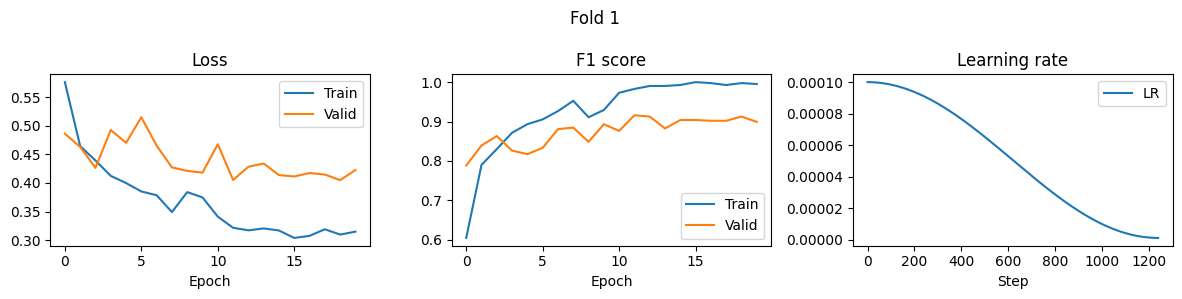

In [25]:
for FOLD in CFG.train_folds:

    seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    display(
        pd.merge(
            fold_valid_data.groupby(by=["label"])["file_name"].count().rename("valid").reset_index(),
            fold_train_data.groupby(by=["label"])["file_name"].count().rename("train").reset_index(),
             on="label", how="left").T,)


    train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_train_data, transforms=train_transforms)
    valid_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
            drop_last=True
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True,
        drop_last=False,
    )

    # PREPARE MODEL, OPTIMIZER AND SCHEDULER
    model = timm.create_model(CFG.model_name, in_chans=14, num_classes=2, pretrained=True)
    model = model.to(CFG.device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader),
        )

    # TRAIN FOLD
    learning_rate_history = []
    train_loss_history = []
    train_score_history = []
    val_loss_history = []
    val_score_history = []

    best_score = 0
    for epoch in range(0, CFG.epochs):
        train_loss, train_score, train_lr = train_epoch(CFG, model, train_loader, optimizer, scheduler, epoch)
        train_loss_history.append(train_loss)
        train_score_history.append(train_score)
        learning_rate_history.extend(train_lr)

        val_loss, val_score = evaluate_model(CFG, model, valid_loader, epoch)
        val_loss_history.append(val_loss)
        val_score_history.append(val_score)

        if (val_score > best_score):
            print(f"{style.GREEN}New best score: {best_score:.4f} -> {val_score:.4f}{style.END}")
            best_score = val_score
            torch.save(model.state_dict(), f'/home/best_model_fold_{FOLD}.pth')

    # plot train and validation loss, score and LR
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    axes[0].plot(train_loss_history, label="Train")
    axes[0].plot(val_loss_history, label="Valid")
    axes[0].title.set_text("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(train_score_history, label="Train")
    axes[1].plot(val_score_history, label="Valid")
    axes[1].title.set_text("F1 score")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    axes[2].plot(learning_rate_history, label="LR")
    axes[2].legend()
    axes[2].title.set_text("Learning rate")
    axes[2].set_xlabel("Step")
    fig.suptitle(f"Fold {FOLD}")
    fig.tight_layout()
    plt.show()

# Submission

In [26]:
import gc
import ctypes

def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

clean_memory()

## Dataset

In [27]:
from torch.utils.data import DataLoader, Dataset

test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=False),
])

class ImageTestDataset(Dataset):
    def __init__(
        self,
        folder,
        file_names,
        transforms=None,
    ):
        self.folder = folder
        self.file_names = file_names
        self.transforms = transforms

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image = tifffile.imread(f"{self.folder}{self.file_names[index]}")
        image = feature_engineering(image)
        image = self.transforms(image)
        return {"image": image}

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Inference

In [28]:
def inference(cfg, model, data_loader):
    model.eval()
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    for step, data in tk0:
        input = data["image"].to(cfg.device, non_blocking=True)

        with torch.no_grad():
            logits = model(input)

        predictions.append(logits.detach().cpu())

    predictions = torch.cat(predictions, dim=0)
    predictions = F.sigmoid(predictions)
    return predictions[:, 1]

In [29]:
test_data = pd.read_csv(f'{DATA_FOLDER}uploadsample.csv', names=["file_name", "label"], header=None)
test_data["probability"] = 0

test_dataset = ImageTestDataset(TEST_DATA_FOLDER, test_data["file_name"].values, test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=False,
    drop_last=False,
)

In [30]:
seed_everything(CFG.seed)

for FOLD in CFG.train_folds:
    print("Inference for fold:", FOLD)
    model = timm.create_model(CFG.model_name, in_chans=14, num_classes=2, pretrained=False)
    model = model.to(CFG.device)

    model.load_state_dict(torch.load(f"/home/best_model_fold_{FOLD}.pth", map_location=CFG.device))
    predictions = inference(CFG, model, test_loader)

    # average predictions from fold models
    test_data["probability"] += predictions.numpy() / len(CFG.train_folds)

Inference for fold: 0


100%|██████████| 78/78 [02:41<00:00,  2.07s/it]


Inference for fold: 1


100%|██████████| 78/78 [02:41<00:00,  2.06s/it]


<Axes: xlabel='probability', ylabel='Count'>

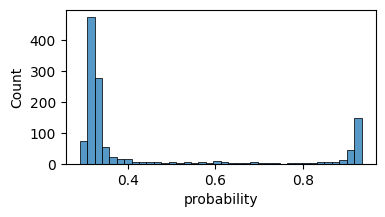

In [31]:
plt.figure(figsize=(4,2))
sns.histplot(test_data["probability"])

In [32]:
THRESHOLD = 0.8
test_data["label"] = (test_data["probability"] > THRESHOLD).astype(int)
print("Positive predictions:", test_data["label"].sum())

Positive predictions: 223


In [33]:
from google.colab import files
test_data[["file_name", "label"]].to_csv("/home/submission.csv", index=False, header=None)
files.download('/home/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>